In [290]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from IPython.display import HTML, display

## Gather Data



In [291]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [292]:
# Download the tsv file using the Requests library and the given URL
url =' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open('image-predictions.tsv', 'wb') as f:
        f.write(r.content)
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Fetching Data from the Twitter API**
- since I'm having truoble of getting a devoper account, I will be using the provided files.

In [293]:
'''
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

'''

'\nimport tweepy\nfrom tweepy import OAuthHandler\nimport json\nfrom timeit import default_timer as timer\n\n# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file\n# These are hidden to comply with Twitter\'s API terms and conditions\nconsumer_key = \'HIDDEN\'\nconsumer_secret = \'HIDDEN\'\naccess_token = \'HIDDEN\'\naccess_secret = \'HIDDEN\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:\n# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to\n# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv\n# NOTE TO REVIEWER: this student had mobile verification issues so the following\n# Twitter API code was sent to this student from a Udacity instructor\n# Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = df_1.

In [294]:
df_list = []

with open('tweet-json.txt') as file:
    for l in file:
        tweet = json.loads(l)
        
        df_list.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
       
df_tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


 ## Assess Data:


In [295]:
df_twitter_archive.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [296]:
df_twitter_archive[df_twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [297]:
df_twitter_archive.name.value_counts()

None            745
a               55 
Charlie         12 
Cooper          11 
Oliver          11 
Lucy            11 
Penny           10 
Lola            10 
Tucker          10 
Winston         9  
Bo              9  
the             8  
Sadie           8  
an              7  
Daisy           7  
Toby            7  
Buddy           7  
Bailey          7  
Jack            6  
Oscar           6  
Bella           6  
Leo             6  
Stanley         6  
Milo            6  
Scout           6  
Koda            6  
Rusty           6  
Dave            6  
Jax             6  
Finn            5  
               ..  
Ed              1  
Rhino           1  
Edmund          1  
Brandonald      1  
by              1  
Willow          1  
Grizzwald       1  
Rontu           1  
Fynn            1  
Tito            1  
Anthony         1  
Halo            1  
Sora            1  
Monty           1  
Ziva            1  
Zara            1  
Farfle          1  
Geno            1  
Norman          1  


In [298]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [299]:
df_image_predictions.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [300]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Quality

**df_twitter_archive table**

- Missing data in expanded_urls (Tweets without images).
- 181 Retweets.
- Incorrect dog names.
- Missing values in dog names.
- Wrong datatype for tweet_id.
- Wrong datatype for timestamp. 
- Unclear data in the source column.
- Dog stage's type is not categorical.

**df_image_predictions table.**
- Missing records (2075 instead of 2356).
- Lowercase breed names in p1, p2, p3 and '_' is used instead of space.


## Tidiness
- Merge all three data frames.
- Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo).
- Combine rating_numerator and rating_denominator columns.
- Drop unneeded columns.

## Clean Data


In [301]:
# Create copies of the original dataframes
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_tweet_clean = df_tweet.copy()

**1 - Remove all retweets**

**Define**: Remove 181 columns which are retweets and detected by the columns: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp. Remove retweets by keeping the null rows of retweeted_status_id column.

**Code:**

In [302]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

**Test**

In [303]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

**Missing data in expanded_urls**

**Define:** Remove any tweet that does not have an expanded_urls by keeping the non null data in the expanded_urls column.

**Code:**

In [304]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.expanded_urls.notnull()]

In [305]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: float64(4), int64(3), object(1

**Merging all data frames**

**Define**: Merge the df_tweet_clean and df_image_predictions tables to the df_twitter_archive_clean table, both joining on tweet_id. I will do this cleaning procces now so I can continue cleaning the rest of issues.

**Code:**



In [306]:
# 1- Merge df_tweet_clean table with df_twitter_archive_clean on tweet_id
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweet_clean, 
                                    on = ['tweet_id'], how = 'left')
# 2- Merge df_image_predictions table with the df_twitter_archive_clean on tweet_id
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_predictions, 
                                    on = ['tweet_id'], how = 'left')

**Test:**

In [307]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
retweet_count                 2117 non

**Keep tweets with images only**

**Define**: Remove all tweets with no images by keeping the non null data in the jpg_url column.

**Code:**

In [308]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.jpg_url.notnull()]

**Test:**

In [309]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
retweet_count                 1994 non

## Drop unneeded columns

**Define:** Drop all columns related to the retweets and the replies: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id.

**Code:**

In [310]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id',
                              'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

**Test:**

In [311]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 25 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
retweet_count         1994 non-null int64
favorite_count        1994 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null 

**Combine dog stage columns into one column (doggo, floofer, pupper, and puppo).**

**Define**: Create a new column named dog_stage. Extract doggo, floofer, pupper and puppo from the text column using pandas' str.extact method and place them into the dog_stage column. Fill the null values with None.

**Code:**

In [312]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['text'].str.extract('(doggo|floof|pupper|puppo)',
                                                                             expand=True)
df_twitter_archive_clean = df_twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1)
df_twitter_archive_clean['dog_stage'].fillna('None', inplace=True)

In [313]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
retweet_count         1994 non-null int64
favorite_count        1994 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    1994 non-null object
p3_conf               1994 non-null float64
p3_dog                1994 non-nul

**Wrong and missing dog names**

**Define:** Names are probably extracted after the statements 'This is','Here is', 'hello to', 'Meet'. So that is why we have lots of words in the name column such that; a, an, the, etc. Notice that all of those are lowercase. Find the lowercase names in name cloumn and re-extract the names that come after the statements: 'name is' and 'named'. Replace the rest of the lowercase names with 'None'. Also, change the name 'O' with "O'Malley".

**Code:**

In [314]:
df_twitter_archive_clean[df_twitter_archive_clean['name'].str.len() == 1][['name', 'text']].head(5)

,name,text
51,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
497,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
596,O,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
618,a,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
795,a,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW


In [315]:
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].str.replace('O', "O'Malley")

In [316]:
df_twitter_archive_clean.query('name == "a"')['text'].count()

55

In [317]:
# Display the texts
pd.set_option('display.max_colwidth',-1)

df_twitter_archive_clean.query('name == "a"')['text']

51      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
497     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
618     Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn               
795     This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
797     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
808     This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2                     
838     This is 

In [318]:
# Mis-extracted names are all lowercase
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()][['name', 'text']]

,name,text
21,such,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
51,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
142,quite,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
158,quite,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x"
292,one,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK"
426,incredibly,We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi
497,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
618,a,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
633,very,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10 https://t.co/qlUDuPoE3d
659,my,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB


In [319]:
df_changed_names = df_twitter_archive_clean[df_twitter_archive_clean['name'].str.islower()]
for text in df_changed_names.text:
    f = re.findall(r'(?:named|name is)\s(\w+)', text)
    m = df_twitter_archive_clean['text'] == text
    if len(f) > 0:
        df_twitter_archive_clean.loc[m, 'name'] = f[0]
    else:
        df_twitter_archive_clean.loc[m, 'name'] = 'None'

In [320]:
df_twitter_archive_clean[df_twitter_archive_clean['name'].str.islower()]['name'].count()

0

In [321]:
df_twitter_archive_clean.query('name == "None"')['name'].count()

622

In [322]:
# We have to do the same procces with 'None' names and recheck it.
df_None_names = df_twitter_archive_clean[df_twitter_archive_clean['name']== 'None']
for text in df_None_names.text:
    f = re.findall(r'(?:named|name is)\s(\w+)', text)
    m = df_twitter_archive_clean['text'] == text
    if len(f) > 0:
        df_twitter_archive_clean.loc[m, 'name'] = f[0]
    else:
        df_twitter_archive_clean.loc[m, 'name'] = 'None'

**Test:**

In [323]:
df_twitter_archive_clean[df_twitter_archive_clean['name'].str.islower()]['name'].count()

0

In [324]:
df_twitter_archive_clean.query('name == "None"')['name'].count()

615

In [325]:
df_twitter_archive_clean.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,8853,39467,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,6514,33819,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,4328,25461,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,8964,42908,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,9774,41048,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,3261,20562,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,2158,12041,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,16716,56848,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.0

**Create one column that combines rating_numerator and rating_denominator**

**Define:** Create a rating column by dividing rating_numerator values by rating_denominator values.

**Code:**

In [326]:
df_twitter_archive_clean['rating'] = df_twitter_archive_clean.rating_numerator / df_twitter_archive_clean.rating_denominator

**Test:**

In [327]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
retweet_count         1994 non-null int64
favorite_count        1994 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    1994 non-null object
p3_conf               1994 non-null float64
p3_dog                1994 non-nul

In [328]:
df_twitter_archive_clean.rating.value_counts()

1.200000      454
1.000000      421
1.100000      402
1.300000      261
0.900000      151
0.800000      95 
0.700000      51 
1.400000      35 
0.500000      34 
0.600000      32 
0.300000      19 
0.400000      15 
0.200000      10 
0.100000      4  
0.000000      2  
177.600000    1  
2.600000      1  
3.428571      1  
0.636364      1  
0.818182      1  
42.000000     1  
7.500000      1  
2.700000      1  
Name: rating, dtype: int64

In [329]:
# Removing outliers for better analysis
df_twitter_archive_clean.query('rating == 3.4285714285714284')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
405,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,1655,5927,...,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,None,3.428571


In [330]:
# Dropping outliers
df_twitter_archive_clean.query('rating == 42.00')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
1840,670842764863651840,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,None,4324,7989,...,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False,None,42.0


In [331]:
df_twitter_archive_clean.query('rating == 177.600')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
772,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,2772,5569,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,None,177.6


In [332]:
df_twitter_archive_clean.query('rating == 7.500000')  

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
531,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,7069,20296,...,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,None,7.5


In [333]:
df_twitter_archive_clean.query('rating == 2.700000 ') 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
588,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,1885,7320,...,0.946718,True,cocker_spaniel,0.01595,True,Lhasa,0.006519,True,None,2.7


In [334]:
df_twitter_archive_clean.query('rating == 2.600000') 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
1486,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,542,1879,...,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,pupper,2.6


In [335]:
df_twitter_archive_clean = df_twitter_archive_clean.drop([1840,772,531,588,1486,405],axis=0)

In [336]:
df_twitter_archive_clean.rating.value_counts()

1.200000    454
1.000000    421
1.100000    402
1.300000    261
0.900000    151
0.800000    95 
0.700000    51 
1.400000    35 
0.500000    34 
0.600000    32 
0.300000    19 
0.400000    15 
0.200000    10 
0.100000    4  
0.000000    2  
0.636364    1  
0.818182    1  
Name: rating, dtype: int64

**Dog stage's type to categorical**

**Define:** We need to convert dog_stage to categorical data type.

**Code:**

In [337]:
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')

**Test:**

In [338]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1988 non-null int64
timestamp             1988 non-null object
source                1988 non-null object
text                  1988 non-null object
expanded_urls         1988 non-null object
rating_numerator      1988 non-null int64
rating_denominator    1988 non-null int64
name                  1988 non-null object
retweet_count         1988 non-null int64
favorite_count        1988 non-null int64
jpg_url               1988 non-null object
img_num               1988 non-null float64
p1                    1988 non-null object
p1_conf               1988 non-null float64
p1_dog                1988 non-null object
p2                    1988 non-null object
p2_conf               1988 non-null float64
p2_dog                1988 non-null object
p3                    1988 non-null object
p3_conf               1988 non-null float64
p3_dog                1988 non-nul

**Wrong datatype for tweet_id.**

**Define:** We need to convert tweet_id to string data type.

**Code:**

In [339]:
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)

**Test:**

In [340]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1988 non-null object
timestamp             1988 non-null object
source                1988 non-null object
text                  1988 non-null object
expanded_urls         1988 non-null object
rating_numerator      1988 non-null int64
rating_denominator    1988 non-null int64
name                  1988 non-null object
retweet_count         1988 non-null int64
favorite_count        1988 non-null int64
jpg_url               1988 non-null object
img_num               1988 non-null float64
p1                    1988 non-null object
p1_conf               1988 non-null float64
p1_dog                1988 non-null object
p2                    1988 non-null object
p2_conf               1988 non-null float64
p2_dog                1988 non-null object
p3                    1988 non-null object
p3_conf               1988 non-null float64
p3_dog                1988 non-nu

**Wrong datatype for timestamp .**

**Define:** We need to convert timestamp  to datetime data type.

**Code:**

In [341]:
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)

**Test:**

In [342]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1988 non-null object
timestamp             1988 non-null datetime64[ns]
source                1988 non-null object
text                  1988 non-null object
expanded_urls         1988 non-null object
rating_numerator      1988 non-null int64
rating_denominator    1988 non-null int64
name                  1988 non-null object
retweet_count         1988 non-null int64
favorite_count        1988 non-null int64
jpg_url               1988 non-null object
img_num               1988 non-null float64
p1                    1988 non-null object
p1_conf               1988 non-null float64
p1_dog                1988 non-null object
p2                    1988 non-null object
p2_conf               1988 non-null float64
p2_dog                1988 non-null object
p3                    1988 non-null object
p3_conf               1988 non-null float64
p3_dog                198

**Unclear data in the source column.**

**Define:** Make the source readable and clear in the source column by re-extracting the source with regex.


**Code:**

In [343]:
df_twitter_archive_clean.source = df_twitter_archive_clean.source.apply(lambda x: re.findall(r'>(.*)<',x)[0])

**Test:**

In [344]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    1950
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

**Lowercase breed names in p1, p2, p3 and '_' is used instead of space.**

**Define:** Replace the character '_' with space by using str.extract method and capitalize the first letters.

**Code:**

In [345]:
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.replace('_',' ')

In [346]:
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.capitalize()

**Test:**

In [347]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Orange,Bagel,Banana
1,Chihuahua,Pekinese,Papillon
2,Chihuahua,Malamute,Kelpie
3,Paper towel,Labrador retriever,Spatula
4,Basset,English springer,German short-haired pointer


## Store Data


In [348]:
df_twitter_archive_clean.to_csv('twitter_archive_master.csv',index=False)

## Analyze Data

In [349]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,8853,39467,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,None,1.3
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,6514,33819,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,4328,25461,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,8964,42908,...,0.170278,False,Labrador retriever,0.168086,True,Spatula,0.040836,False,None,1.3
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,9774,41048,...,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,None,1.2


In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 23 columns):
tweet_id              1988 non-null int64
timestamp             1988 non-null object
source                1988 non-null object
text                  1988 non-null object
expanded_urls         1988 non-null object
rating_numerator      1988 non-null int64
rating_denominator    1988 non-null int64
name                  1988 non-null object
retweet_count         1988 non-null int64
favorite_count        1988 non-null int64
jpg_url               1988 non-null object
img_num               1988 non-null float64
p1                    1988 non-null object
p1_conf               1988 non-null float64
p1_dog                1988 non-null bool
p2                    1988 non-null object
p2_conf               1988 non-null float64
p2_dog                1988 non-null bool
p3                    1988 non-null object
p3_conf               1988 non-null float64
p3_dog                1988 non-null bo

In [359]:
# Find the dog with the highest rating.
df.loc[df['rating'].idxmax()]

tweet_id              890240255349198849                                                                                                                                           
timestamp             2017-07-26 15:59:51                                                                                                                                          
source                Twitter for iPhone                                                                                                                                           
text                  This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A
expanded_urls         https://twitter.com/dog_rates/status/890240255349198849/photo/1                                                                                              
rating_numerator      14                                                                            

In [361]:
display(HTML('<img src=" https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg" />'))

Cassie has the highest rating 14/10 (1.4). He looks like someone who likes good outfits which explain the haigh rate.

In [364]:
# The most favorite dog 
df.iloc[df['favorite_count'].idxmax()]

tweet_id              822872901745569793                                                                                             
timestamp             2017-01-21 18:26:02                                                                                            
source                Twitter for iPhone                                                                                             
text                  Here's a super supportive puppo participating in the Toronto  #WomensMarch today. 13/10 https://t.co/nTz3FtorBc
expanded_urls         https://twitter.com/dog_rates/status/822872901745569793/photo/1                                                
rating_numerator      13                                                                                                             
rating_denominator    10                                                                                                             
name                  None                                    

In [363]:
display(HTML('<img src="https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg" />'))

This puppo without a name has the highest number of likes and it is a Lakeland terrier. He also has the highest retweet count,132810, it can be easily seen from the descriptive analysis.

In [365]:
# Descriptive analysis
df.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf,rating
count,1.988000e+03,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1988.000000,1.988000e+03,1.988000e+03,1988.000000
mean,7.358197e+17,11.136821,10.535211,2765.925050,8897.936117,1.203722,0.594046,1.345927e-01,6.027390e-02,1.054152
std,6.751476e+16,8.631842,7.331277,4680.251304,12227.454419,0.561512,0.271908,1.007607e-01,5.093793e-02,0.219203
min,6.660209e+17,0.000000,2.000000,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000
25%,6.758399e+17,10.000000,10.000000,623.750000,1978.500000,1.000000,0.362775,5.401683e-02,1.616933e-02,1.000000
50%,7.084132e+17,11.000000,10.000000,1350.000000,4118.500000,1.000000,0.587797,1.175870e-01,4.947920e-02,1.100000
75%,7.878678e+17,12.000000,10.000000,3220.000000,11315.500000,1.000000,0.845599,1.954432e-01,9.162278e-02,1.200000
max,8.924206e+17,204.000000,170.000000,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,1.400000


Text(0,0.5,'Count')

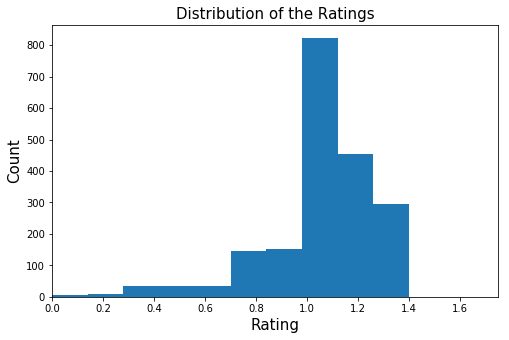

In [366]:
df.rating.plot(kind='hist', xlim=[0,1.75], figsize=(8,5))
plt.title('Distribution of the Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)


The mean dog rating is 1.06 and the ratings are more frequent between 1 and 1.3.

Text(0,0.5,'Count')

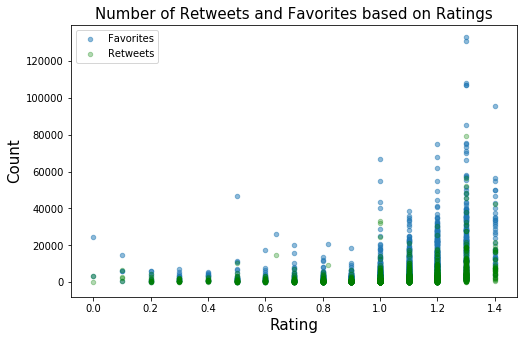

In [370]:
ax = df.plot.scatter(x='rating', y='favorite_count', alpha=0.5, label='Favorites');
df.plot.scatter(x='rating', y='retweet_count', color='green', alpha=0.3, label='Retweets', ax=ax, figsize=(8,5));
plt.title('Number of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)

Text(0,0.5,'Count')

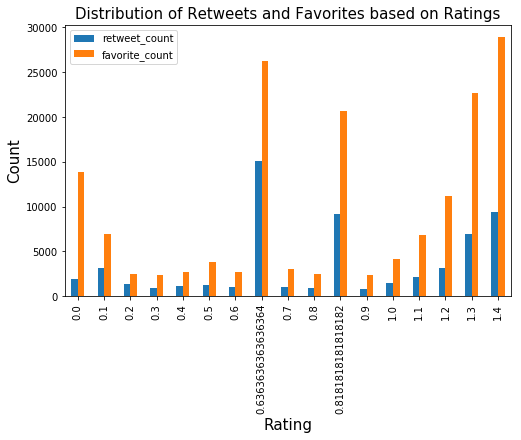

In [371]:
df.groupby('rating')['retweet_count','favorite_count'].mean().plot(kind='bar', figsize=(8,5))
plt.title('Distribution of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)

From this analysis we could say that there's a positive correlation between retweet counts and favorite counts based on ratings.


- For each dog, it's always the favorite counts are higher than the retweet counts.
- The most dogs that was retweeted and liked are the dogs with the ratings between 1.3 and 1.4.

In [372]:
df[['rating','retweet_count','favorite_count']].corr(method = 'pearson')

,rating,retweet_count,favorite_count
rating,1.000000,0.299741,0.402516
retweet_count,0.299741,1.000000,0.912953
favorite_count,0.402516,0.912953,1.000000


Pearson correlation coefficients show that there is indeed a positive correlation between retweet counts and favorite counts. But there is no correlation between ratings and retweet counts, as well as ratings and favorite counts. 


**Concluding Remarks**

- The ratings, retweets and favorites are not only related with the dog images or videos, the humor of the account holder also affects the followers’ decisions.

- I believe I did a good job in re-extracting, cleaning and correcting names and ratings but dog stages needs much more work rather than extraction. Most of the dogs, their stages are not stated in the tweets.
- We could use some more data about dogs it self, for example the dog's age and hoppeis.